<a href="https://colab.research.google.com/github/HIzadi1/RobotEnvironmentPerception_NaiveBayes_vs_GradientBoosting/blob/master/NaiveBayesAndGradientBoosting_RobotEnvironmentPerception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of the project is to find out what kind of surface the robot is operating on using robot`s IMU time series data. Two main category of ML techniues will be explored to tackle the problem: 1) Naive Bayes based clasiffiers, 2) Gradien Boosting techniues.
A %77 accuracy is acheived, improving this accuracy is not the main objective of this work, rather I'd like to explore the above mentioned methods on time series data of dynamical systems as two completely different approach. Bayes inference methods are widely used in estimation theory in one hand and the gradient booditing as a sophisticated ML approach will be explored.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 10]
plt.rcParams['axes.unicode_minus'] = False

Load Training Data

In [0]:
# import data from disk
from google.colab import files
uploaded = files.upload()

import io
X_train_raw = pd.read_csv(io.BytesIO(uploaded['X_train.csv']))

X_train_raw.head()   #ploting the top rows
#X_train_raw.tail()    #ploting the end rows 

Saving X_train.csv to X_train.csv


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [0]:
uploaded = files.upload()

y_train_raw = pd.read_csv(io.BytesIO(uploaded['y_train.csv']))

y_train_raw.head()   #ploting the top rows

Saving y_train.csv to y_train.csv


,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


**Data Exploration/Visualization:**

there are 3810 series of data each with 487680/3810 = 128 number of data points:

In [0]:
n_datapoints_X = int(X_train_raw.shape[0])
n_series = int(X_train_raw['series_id'].nunique());
n_data_per_series=int(n_datapoints_X/n_series);

print('Numer of data series:',X_train_raw['series_id'].nunique())
print('Number of classes:',y_train_raw['group_id'].nunique())

Numer of data series: 3810
Number of classes: 73


Text(0, 0.5, 'Number of data in class')

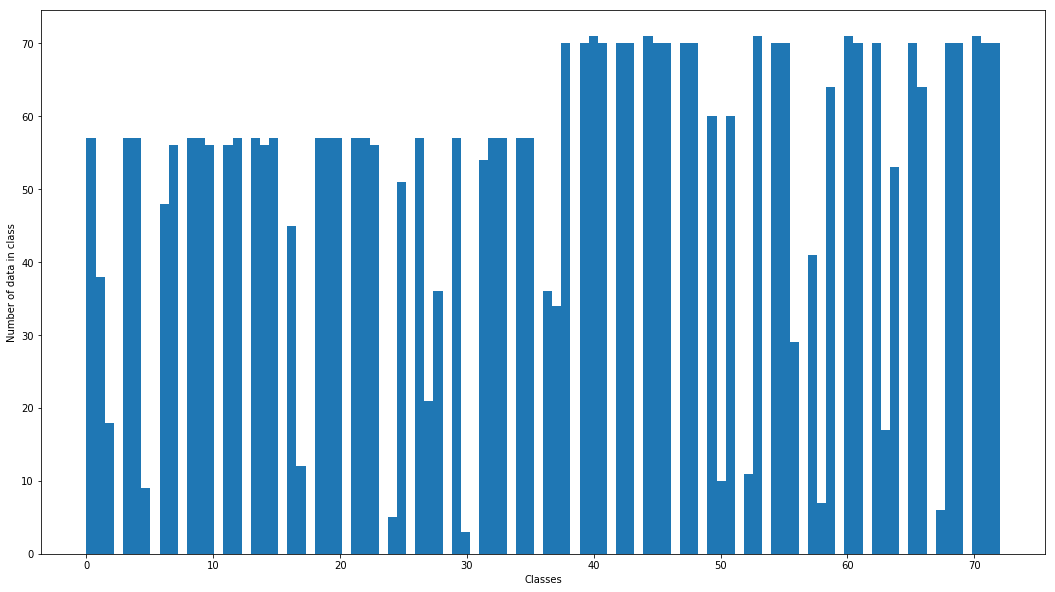

In [0]:
plt.hist(y_train_raw['group_id'].values, bins=100)
plt.xlabel('Classes')
plt.ylabel('Number of data in class')

Ideally equal number of data for all classes should exist to make sure data is not biased towards some classes. Some classes like 31 seem to have relatively small amount of data.

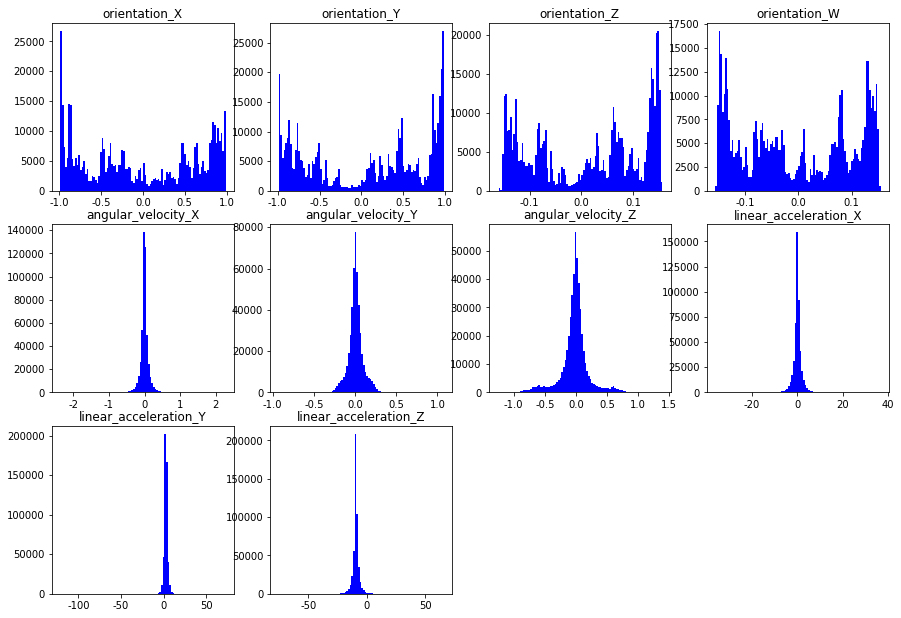

In [0]:
plt.figure(figsize=(15,10.5))
for i, col in enumerate(X_train_raw.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.hist(X_train_raw[col], color='blue', bins=100)
    plt.title(col)

Quaternions are well distributed over their range which implies the full range of orientations are covered. Angular speed and accelertaions have a normal-like distribujtion with mean value of around 0. 

let''s see how the data looks like in a single time series:

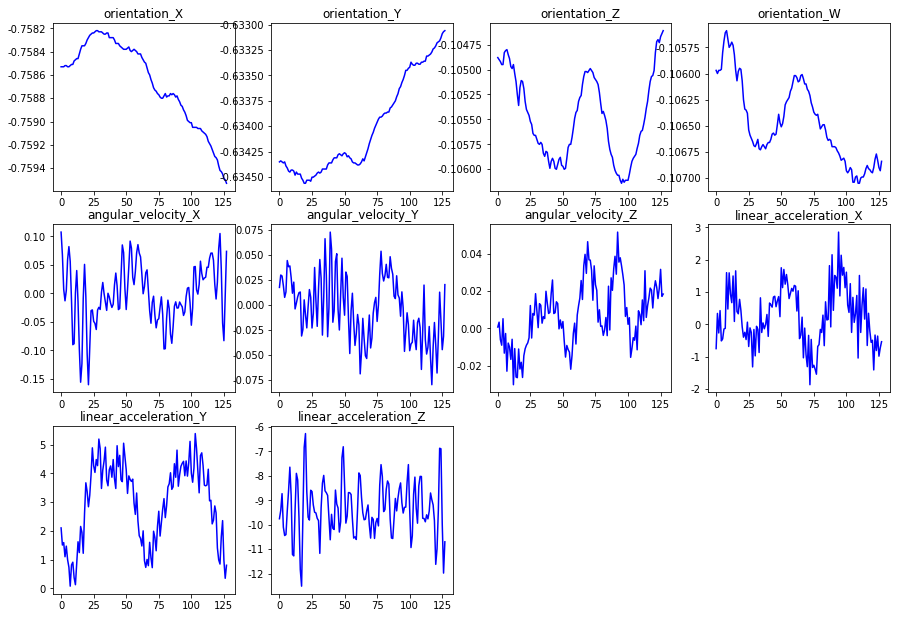

In [0]:
plt.figure(figsize=(15, 10.5))
for i, col in enumerate(X_train_raw.columns[3:]):
              plt.subplot(3,4,i+1)
              plt.plot(X_train_raw.loc[X_train_raw['series_id'] == 0, col], color='blue')
              plt.title(col)

Does it look like a fine_concrete to anyone? :)))
So these are the time-series data for dynamical response of the robot over time for a simple manuver, which definitely can not tell which surface the robot is performing on. Some features need to be generated from these data, that might need some knowledge of Dynamics.  

In [0]:
X_train_df = X_train_raw[['series_id']].drop_duplicates().reset_index(drop=True)
X_train_df.head()

,series_id
0,0
1,1
2,2
3,3
4,4


**Feature Engineering:**

In the first attemp we adopt a purely statistical/probabilistic approach. We look at agregation attributes of data, such as mean, standard deviation, max, min, uantiles, etc.

In [0]:
n_col = 10
n_feature_type = 7; # mean, std, max, min, quantile 0.5, mean(diff)
num_segments = X_train_raw['series_id'].nunique()
feature_list = np.zeros(shape=(num_segments,n_col*n_feature_type))

for i_seg in range(num_segments):
    for i_col, col in enumerate(X_train_raw.columns[13-n_col:]):
                  seg = X_train_raw.loc[X_train_raw['series_id'] == i_seg, col]
                  feature_list[i_seg,0*n_col+i_col] = seg.mean()
                  feature_list[i_seg,1*n_col+i_col] = seg.std()
                  feature_list[i_seg,2*n_col+i_col] = seg.max()
                  feature_list[i_seg,3*n_col+i_col] = seg.min()
                  feature_list[i_seg,4*n_col+i_col] = np.quantile(seg,0.5)
                  feature_list[i_seg,5*n_col+i_col] = np.mean(np.diff(seg))
                  feature_list[i_seg,6*n_col+i_col] = np.max(np.diff(seg))
 
feature_list.shape

y = y_train_raw["group_id"]

**Feature Normalization/Regularization & PCA**

{This section will be added later}

**Naive Bayes Classifier:**

The underlying assumption of Naive Bayes classifier is that all the features are independent. It really outperforms many other classifiers if this condition is met. It doesn not need a lot of training data like many other classifier and trains pretty fast. 
Despite the feature independence criteria it's been used in this project where the motion parameters are somehow dependent to study it''s performance and compare it with other classifiers.
Based on Naive Bayes classifier evaluates the probablity of the featgures belonging to any class. The probablity of a set of feature belonging to a class is equal to the probablity of the class multiplied by the conditional probablity of the specific feature set, given that specific class divided by the likelihood of the feature set (posterior knowledge = prior nowledge * likelihhod/ evidance):

P(Ck|x1,x2,...,xn) = P(Ck)*P(x1,....xn|Ck)/ P(x1,x2,...,xn) 

In classification  P(x1,x2,...,xn) is not of great ineterst because it's independent of class Ck; it's a constant. P(Ck) can be calculated as 1/number of classes or its distribution in training data, which . P(x1,....xn|Ck) is called the event model and defines the distribution of features , for any given class Ck, which will be the same for all classes. For example, for continous data a gaussian distribution can be assumed, where the mean and variance of xi is calculated from training data (binning data based on ck).


In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     feature_list, y, test_size=0.2, random_state=40)

BNB_Model = GaussianNB()

BNB_Model.fit(X_train, y_train)

print('Training Accuracy: ', BNB_Model.score(X_train, y_train))
print('Testing Accuracy: ', BNB_Model.score(X_test, y_test))

Training Accuracy:  0.5721784776902887
Testing Accuracy:  0.573490813648294


Despite some dependency between input features the NB classifier has a fair performance, and no sign of overfitting is observed so far; however, the accuracy is not good enough.

**Features Time Lag**

With this method we extract the features as time series for each series:

In [0]:
Linear_ax = X_train_raw['linear_acceleration_X']
Linear_ay = X_train_raw['linear_acceleration_Y']
Angular_wz = X_train_raw['angular_velocity_Z']

feature_series = np.zeros(shape=(n_series,n_data_per_series*3))
  
#print(feature_series.shape)
for i in range(n_series):
  #print(i)
  feature_series[i,0:n_data_per_series-1] = Linear_ax[i*n_data_per_series:(i+1)*n_data_per_series-1]
  feature_series[i,1*n_data_per_series:2*n_data_per_series-1] = Linear_ay[i*n_data_per_series:(i+1)*n_data_per_series-1]
  feature_series[i,2*n_data_per_series:3*n_data_per_series-1] = Angular_wz[i*n_data_per_series:(i+1)*n_data_per_series-1]

  
print(feature_series.shape)  

(3810, 384)


verifying whether the conversion to time series is performed correctly:

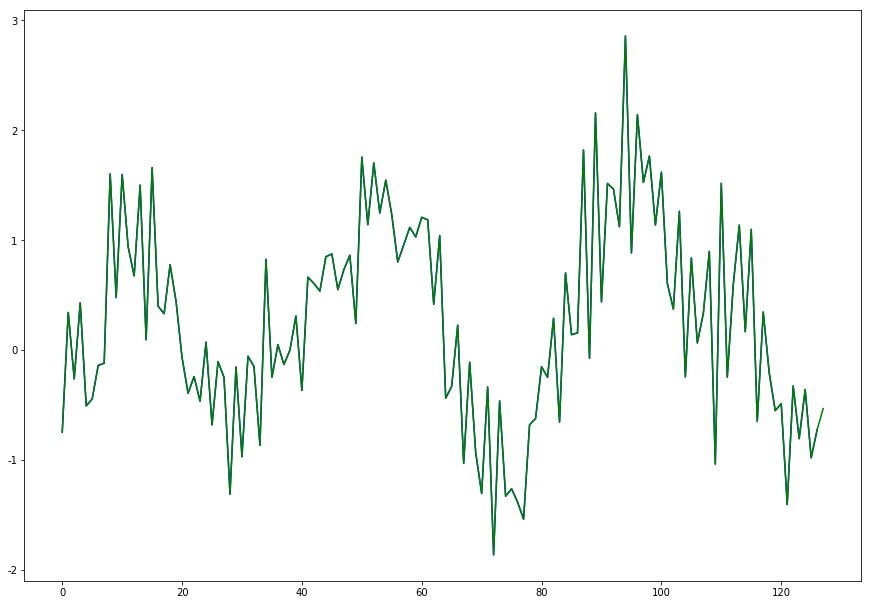

In [0]:
plt.figure(figsize=(15, 10.5))
plt.plot(feature_series[0,0:n_data_per_series-1], color='blue')
plt.plot(Linear_ax[0*n_data_per_series:(0+1)*n_data_per_series], color='green')
#plt.plot(X_train.loc[X_train['series_id'] == 3, X_train['linear_acceleration_X']], color='green')


this time we use Naive Bayes on this time series data:

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     feature_series, y, test_size=0.2, random_state=40)

BNB_Model = GaussianNB()
BNB_Model.fit(feature_series, y)

print('Training Accuracy: ', BNB_Model.score(X_train, y_train))
print('Testing Accuracy: ', BNB_Model.score(X_test, y_test))

Training Accuracy:  0.19028871391076116
Testing Accuracy:  0.2230971128608924


This makes the performance of Naive Bayes even worse! which makes sense because there's much more dependency on the time series data compared to non series data.

**Ada Boost**

AdaBoost on Aggregation Features:

In [0]:
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(
     feature_list, y, test_size=0.2, random_state=40)

dt = DecisionTreeClassifier() #base classifier
AdaB_Model = AdaBoostClassifier(n_estimators=100, base_estimator=dt,learning_rate=0.5)
AdaB_Model.fit(X_train,y_train)

print('Training Accuracy: ', AdaB_Model.score(X_train, y_train))
print('Testing Accuracy: ', AdaB_Model.score(X_test, y_test))

Training Accuracy:  1.0
Testing Accuracy:  0.6469816272965879


AdaBoost on time series features:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
     feature_series, y, test_size=0.2, random_state=40)

dt = DecisionTreeClassifier() #base classifier
AdaB_Model = AdaBoostClassifier(n_estimators=100, base_estimator=dt,learning_rate=0.5)
AdaB_Model.fit(X_train,y_train)

print('Training Accuracy: ', AdaB_Model.score(X_train, y_train))
print('Testing Accuracy: ', AdaB_Model.score(X_test, y_test))

Training Accuracy:  1.0
Testing Accuracy:  0.06430446194225722


**Gradient Boost**

Gradient Boost on aggregation features:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
     feature_list, y, test_size=0.2, random_state=40)

from sklearn.ensemble import GradientBoostingClassifier 

GB_Model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
GB_Model.fit(X_train, y_train)

print('Training Accuracy: ', GB_Model.score(X_train, y_train))
print('Testing Accuracy: ', GB_Model.score(X_test, y_test))

Training Accuracy:  0.01673228346456693
Testing Accuracy:  0.01968503937007874


Gradient Boost on time series features:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
     feature_series, y, test_size=0.2, random_state=40)

from sklearn.ensemble import GradientBoostingClassifier 

GB_Model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
GB_Model.fit(X_train, y_train)

print('Training Accuracy: ', GB_Model.score(X_train, y_train))
print('Testing Accuracy: ', GB_Model.score(X_test, y_test))

Training Accuracy:  0.028871391076115485
Testing Accuracy:  0.031496062992125984


**XGBoost (Extreme Gradient Boosting):**

XgBoost on aggregation features:

In [0]:
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
     feature_list, y, test_size=0.2, random_state=40)

XGB_Model = XGBClassifier(n_estimators = 100, max_depth = 3)

XGB_Model.fit(X_train,y_train)
#XGB_Model.predict(x_test)

print('Training Accuracy: ', XGB_Model.score(X_train, y_train))
print('Testing Accuracy: ', XGB_Model.score(X_test, y_test))

Training Accuracy:  1.0
Testing Accuracy:  0.7703412073490814


XgBoost on time series features:

In [0]:
from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(
     feature_series, y, test_size=0.2, random_state=40)

XGB_Model = XGBClassifier(n_estimators = 100, max_depth = 3)

XGB_Model.fit(X_train,y_train)
#XGB_Model.predict(x_test)

print('Training Accuracy: ', XGB_Model.score(X_train, y_train))
print('Testing Accuracy: ', XGB_Model.score(X_test, y_test))



**Future Improvement:**

use LSTM to model the dynamics and then Bays to infere